## A study on the timeseries forecasting method: ARIMA

[Data used](https://disease.sh)

### Getting the data

In [1]:
# initial imports
import pandas as pd
import numpy as np 

from TSErrors import FindErrors

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go


In [2]:
confirmed_global = pd.read_csv(r"./data/country_confirmed.csv")
deaths_global = pd.read_csv(r"./data/country_deaths.csv")

In [3]:
def get_data(
    confirmed=confirmed_global, deaths=deaths_global
):
    deaths = deaths.groupby("country").sum().T
    confirmed = confirmed.groupby("country").sum().T

    deaths.index = pd.to_datetime(deaths.index, infer_datetime_format=True)
    confirmed.index = pd.to_datetime(confirmed.index, infer_datetime_format=True)

    return deaths, confirmed

In [4]:
def create_data_frame(dataframe, country):

    deaths, confirmed = get_data()

    if dataframe == "deaths":
        data = pd.DataFrame(
            index=deaths.index, data=deaths[country].values, columns=["Total"]
        )

    elif dataframe == "confirmed":
        data = pd.DataFrame(
            index=confirmed.index, data=confirmed[country].values, columns=["Total"]
        )

    data = data[(data != 0).all(1)]

    data_diff = data.diff()

    # Removing the first value from data_diff 
    # It had no previous value and is a NaN after taking the difference
    data_diff = data_diff[1:]

    return data, data_diff

In [5]:
confirmed_dfs = create_data_frame("confirmed", "India")
confirmed_daily = confirmed_dfs[1]

In [6]:
confirmed_daily.tail()

,Total
2022-03-03,6396.0
2022-03-04,5921.0
2022-03-05,5476.0
2022-03-06,4362.0
2022-03-07,3993.0


In [7]:
# plotting our daily cases
px.line(confirmed_daily, title="Daily Confirmed Cases in India")

### Model identification

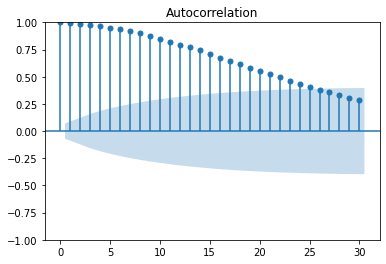

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
acf = plot_acf(confirmed_daily["Total"], lags=30)


In [9]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(ts):
    result = adfuller(ts)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Lags: {result[2]}')
    print(f'Number of obs: {result[3]}')


In [10]:
adfuller_test(confirmed_daily["Total"])

ADF Statistic: -2.6607006324898412
p-value: 0.08108912736647178
Lags: 20
Number of obs: 746


As seen in the above tests:

1. The ACF plot decreases/declines slowly for different lags
2. The p-value returned by the Dicky-Fuller test is >0.05

Both of these observations are not consistent with the null hypothesis that the data is stationary. Therefore we cannot use ARIMA(p,0,q) or an ARMA model for our time series.

Our next step is to find the order of differencing for our ARIMA model to convert it into stationary data. 
